# Analiza uspeha studenata / Student Performance Data Analysis

U ovoj analizi istražujemo performanse studenata koristeći različite tehnike klasterizacije. Cilj je identifikovati grupe studenata sa sličnim karakteristikama i obrascima ponašanja.

## 1. Data Loading and Merging

# Opis atributa / Dataset Features

## Osnovni podaci / Basic Information
- `school` - Naziv škole (binarna vrednost: 'GP' - Gabriel Pereira ili 'MS' - Mousinho da Silveira)
- `sex` - Pol učenika ('F' - ženski ili 'M' - muški)
- `age` - Starost učenika (numerička vrednost)
- `address` - Tip adrese stanovanja ('U' - urbana ili 'R' - ruralna)
- `famsize` - Veličina porodice ('LE3' - manje ili jednako 3 ili 'GT3' - više od 3)
- `Pstatus` - Status suživota roditelja ('T' - žive zajedno ili 'A' - žive odvojeno)

## Obrazovanje roditelja / Parent's Education
- `Medu` - Obrazovanje majke (0 - bez obrazovanja do 4 - visoko obrazovanje)
- `Fedu` - Obrazovanje oca (0 - bez obrazovanja do 4 - visoko obrazovanje)
- `Mjob` - Posao majke
- `Fjob` - Posao oca

## Akademski podaci / Academic Data
- `reason` - Razlog izbora škole
- `guardian` - Staratelj učenika
- `traveltime` - Vreme putovanja do škole (1 - <15 min. do 4 - >60 min.)
- `studytime` - Nedeljno vreme učenja (1 - <2 sata do 4 - >10 sati)
- `failures` - Broj prethodnih neuspelih razreda
- `schoolsup` - Dodatna obrazovna podrška
- `famsup` - Porodična obrazovna podrška
- `paid` - Dodatne plaćene časove
- `activities` - Vannastavne aktivnosti
- `nursery` - Pohađao/la obdanište
- `higher` - Želi više obrazovanje
- `internet` - Pristup internetu kod kuće
- `romantic` - U romantičnoj vezi

## Socijalni i zdravstveni faktori / Social and Health Factors
- `famrel` - Kvalitet porodičnih odnosa (od 1 - vrlo loš do 5 - odličan)
- `freetime` - Slobodno vreme nakon škole (od 1 - vrlo malo do 5 - vrlo mnogo)
- `goout` - Izlasci sa prijateljima (od 1 - vrlo retko do 5 - vrlo često)
- `Dalc` - Konzumiranje alkohola radnim danima (od 1 - vrlo retko do 5 - vrlo često)
- `Walc` - Konzumiranje alkohola vikendom (od 1 - vrlo retko do 5 - vrlo često)
- `health` - Trenutno zdravstveno stanje (od 1 - vrlo loše do 5 - vrlo dobro)
- `absences` - Broj izostanaka sa nastave

## Ocene / Grades
- `G1` - Ocena iz prvog perioda (od 0 do 20)
- `G2` - Ocena iz drugog perioda (od 0 do 20)
- `G3` - Finalna ocena (od 0 do 20)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import LocalOutlierFactor


df_mat = pd.read_csv('student-mat.csv', sep=',')
df_por = pd.read_csv('student-por.csv', sep=',')

print("Shape of the Math dataset:", df_mat.shape)
print("Shape of the Portuguese dataset:", df_por.shape)


common_cols = [
    'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
    'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures',
    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
    'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'
]

# Before merging, I'll rename the grade columns to be course-specific to avoid conflicts and preserve all grade information.
df_mat = df_mat.rename(columns={'G1': 'G1_Math', 'G2': 'G2_Math', 'G3': 'G3_Math'})
df_por = df_por.rename(columns={'G1': 'G1_Por', 'G2': 'G2_Por', 'G3': 'G3_Por'})

# Now, I'll perform an outer merge on the common columns. This ensures that all students from both datasets are included.
# If a student is only in one course, the grades for the other course will be NaN.
# If a student is in both, their records will be combined into a single row with both sets of grades.
df_final_merged = pd.merge(df_mat, df_por, on=common_cols, how='outer', suffixes=('_mat', '_por'))

print("\nShape of the final merged dataset:", df_final_merged.shape)
print("First 5 rows of the merged dataset:")
print(df_final_merged.head())

# Let's get a quick overview of the dataset, including data types and non-null counts.
print("\nDataset Information:")
df_final_merged.info()

# It's important to check for missing values, especially in the newly merged grade columns.
print("\nMissing values before handling (only showing columns with missing data):")
print(df_final_merged.isnull().sum()[df_final_merged.isnull().sum() > 0])


Shape of the Math dataset: (395, 33)
Shape of the Portuguese dataset: (649, 33)

Shape of the final merged dataset: (1005, 36)
First 5 rows of the merged dataset:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob   Fjob  ...  \
0     GP   F   15       R     GT3       T     1     1  at_home  other  ...   
1     GP   F   15       R     GT3       T     1     1  at_home  other  ...   
2     GP   F   15       R     GT3       T     1     1    other  other  ...   
3     GP   F   15       R     GT3       T     1     1    other  other  ...   
4     GP   F   15       R     GT3       T     1     1    other  other  ...   

  Dalc Walc  health  absences  G1_Math G2_Math G3_Math G1_Por G2_Por G3_Por  
0    1    1       1         4      NaN     NaN     NaN   13.0   13.0   13.0  
1    1    1       1         2      7.0    10.0    10.0    NaN    NaN    NaN  
2    1    1       1         2      NaN     NaN     NaN    8.0    9.0    9.0  
3    2    4       5         2      NaN     NaN     NaN  

## 2. Data Preparation

In [57]:
# For our clustering analysis, we need to prepare the data. This involves handling missing values, encoding categorical features, and scaling numerical features.

# First, I'll define all grade columns. Missing grades (NaN) will be imputed with 0, assuming that if a student doesn't have a grade for a course, they didn't take it or received a 0.
grade_cols = ['G1_Math', 'G2_Math', 'G3_Math', 'G1_Por', 'G2_Por', 'G3_Por']
for col in grade_cols:
    df_final_merged[col] = df_final_merged[col].fillna(0)

# Now, let's separate our features into numerical and categorical types for preprocessing.
# I'll include the grade columns as features for clustering, as they are important aspects of student performance.
numerical_features = df_final_merged.select_dtypes(include=np.number).columns.tolist()
categorical_features = df_final_merged.select_dtypes(include='object').columns.tolist()

print("\nNumerical features identified:", numerical_features)
print("Categorical features identified:", categorical_features)

# I'll use a ColumnTransformer to apply different preprocessing steps to different types of features:
# - StandardScaler for numerical features (to ensure all features contribute equally to distance calculations).
# - OneHotEncoder for categorical features (to convert them into a numerical format).
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Applying the preprocessing pipeline to our merged dataset.
X_preprocessed = preprocessor.fit_transform(df_final_merged)

# To make the preprocessed data understandable, I'll get the feature names after one-hot encoding.
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)

print("\nShape of the preprocessed data:", X_preprocessed_df.shape)
print("First 5 rows of the preprocessed data:")
print(X_preprocessed_df.head())



Numerical features identified: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1_Math', 'G2_Math', 'G3_Math', 'G1_Por', 'G2_Por', 'G3_Por']
Categorical features identified: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

Shape of the preprocessed data: (1005, 62)
First 5 rows of the preprocessed data:
        age      Medu      Fedu  traveltime  studytime  failures    famrel  \
0 -1.410225 -1.429274 -1.258412    0.643163   2.433751 -0.405909 -0.986589   
1 -1.410225 -1.429274 -1.258412    0.643163   2.433751  1.110592 -0.986589   
2 -1.410225 -1.429274 -1.258412    2.006830  -1.163190  1.110592  1.148011   
3 -1.410225 -1.429274 -1.258412   -0.720505   0.035790 -0.405909 -0.986589   
4 -1.410225 -1.429274 -1.258412   -0.720505   0.035790  2.627093 -0.986589   

   freeti

### Outlier Handling

In [58]:
# Outliers can significantly affect clustering results. I'll use Local Outlier Factor (LOF) to detect and handle them.
# LOF measures the local deviation of density of a given data point with respect to its neighbors.
# I'll set `contamination` to 0.05, meaning I expect about 5% of the data to be outliers.
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_scores = lof.fit_predict(X_preprocessed_df)

# -1 indicates an outlier, 1 indicates an inlier.
outliers_data = X_preprocessed_df[outlier_scores == -1]
inliers_data = X_preprocessed_df[outlier_scores == 1]

print(f"Number of outliers detected by LOF: {len(outliers_data)}")

# For clustering, removing outliers is often a good strategy to ensure that clusters represent the main patterns in the data.
X_cleaned = X_preprocessed_df[outlier_scores == 1].reset_index(drop=True)
df_cleaned = df_final_merged[outlier_scores == 1].reset_index(drop=True)

print("Shape of data after outlier removal:", X_cleaned.shape)
print("Original dataset shape after outlier removal:", df_cleaned.shape)

# If the number of outliers is unusually high or low, it might indicate an issue with the `contamination` parameter or the data itself.
# For this analysis, I'll proceed with the cleaned data.


Number of outliers detected by LOF: 51
Shape of data after outlier removal: (954, 62)
Original dataset shape after outlier removal: (954, 36)
Shape of data after outlier removal: (954, 62)
Original dataset shape after outlier removal: (954, 36)


## 3. Descriptive Analysis


Descriptive statistics for numerical features (after outlier removal):
              age        Medu        Fedu  traveltime   studytime    failures  \
count  954.000000  954.000000  954.000000  954.000000  954.000000  954.000000   
mean    16.707547    2.588050    2.376310    1.497904    1.962264    0.245283   
std      1.174853    1.120778    1.092714    0.693619    0.818620    0.626960   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    1.000000    1.000000    1.000000    0.000000   
50%     17.000000    3.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     21.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  954.000000  954.000000  954.000000  954.000000  954.000000  954.000000   
mean     3.958071    3.185535    3.1

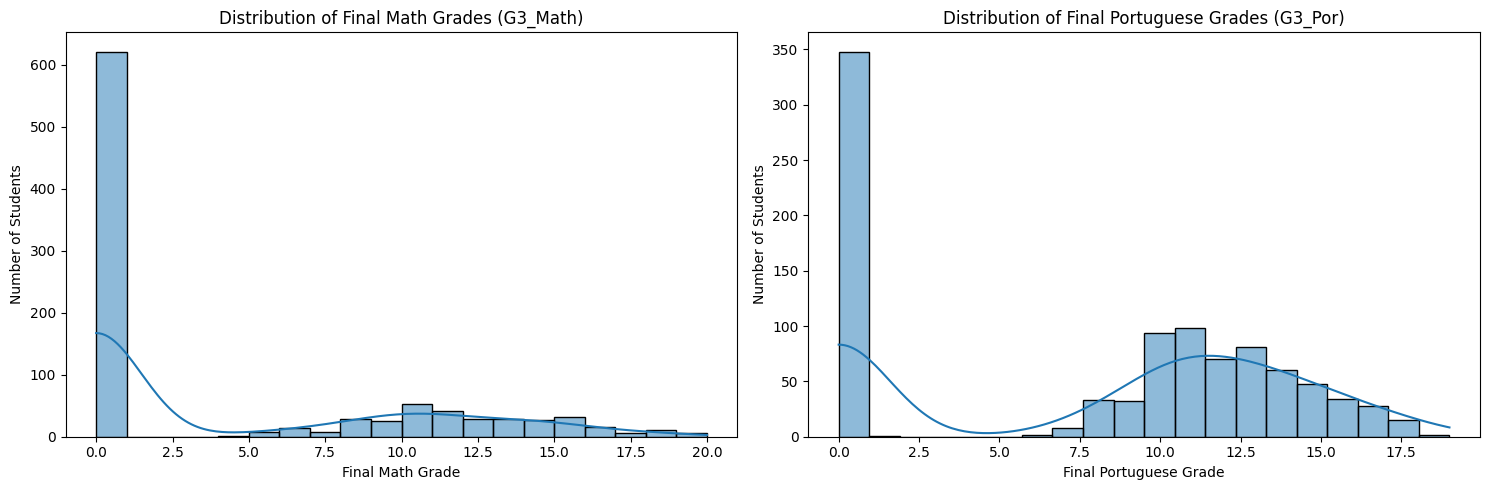

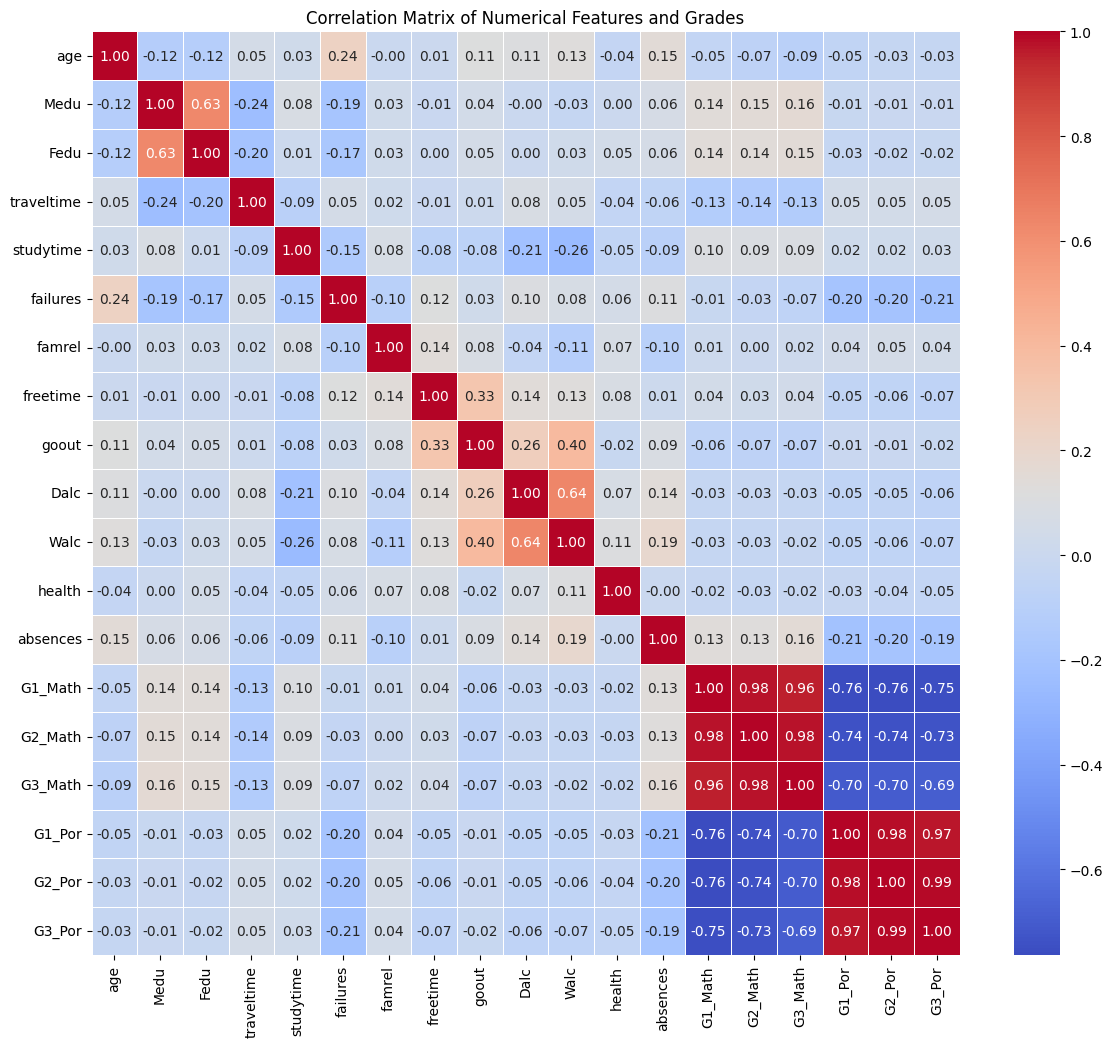

C:\Users\Predrag\AppData\Local\Temp\ipykernel_10236\2030481285.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x=col, palette='viridis')
C:\Users\Predrag\AppData\Local\Temp\ipykernel_10236\2030481285.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x=col, palette='viridis')
C:\Users\Predrag\AppData\Local\Temp\ipykernel_10236\2030481285.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x=col, palette='viridis')
C:\Users\Predrag\AppData\Local\Temp\ipykernel_10236\2030481285.p

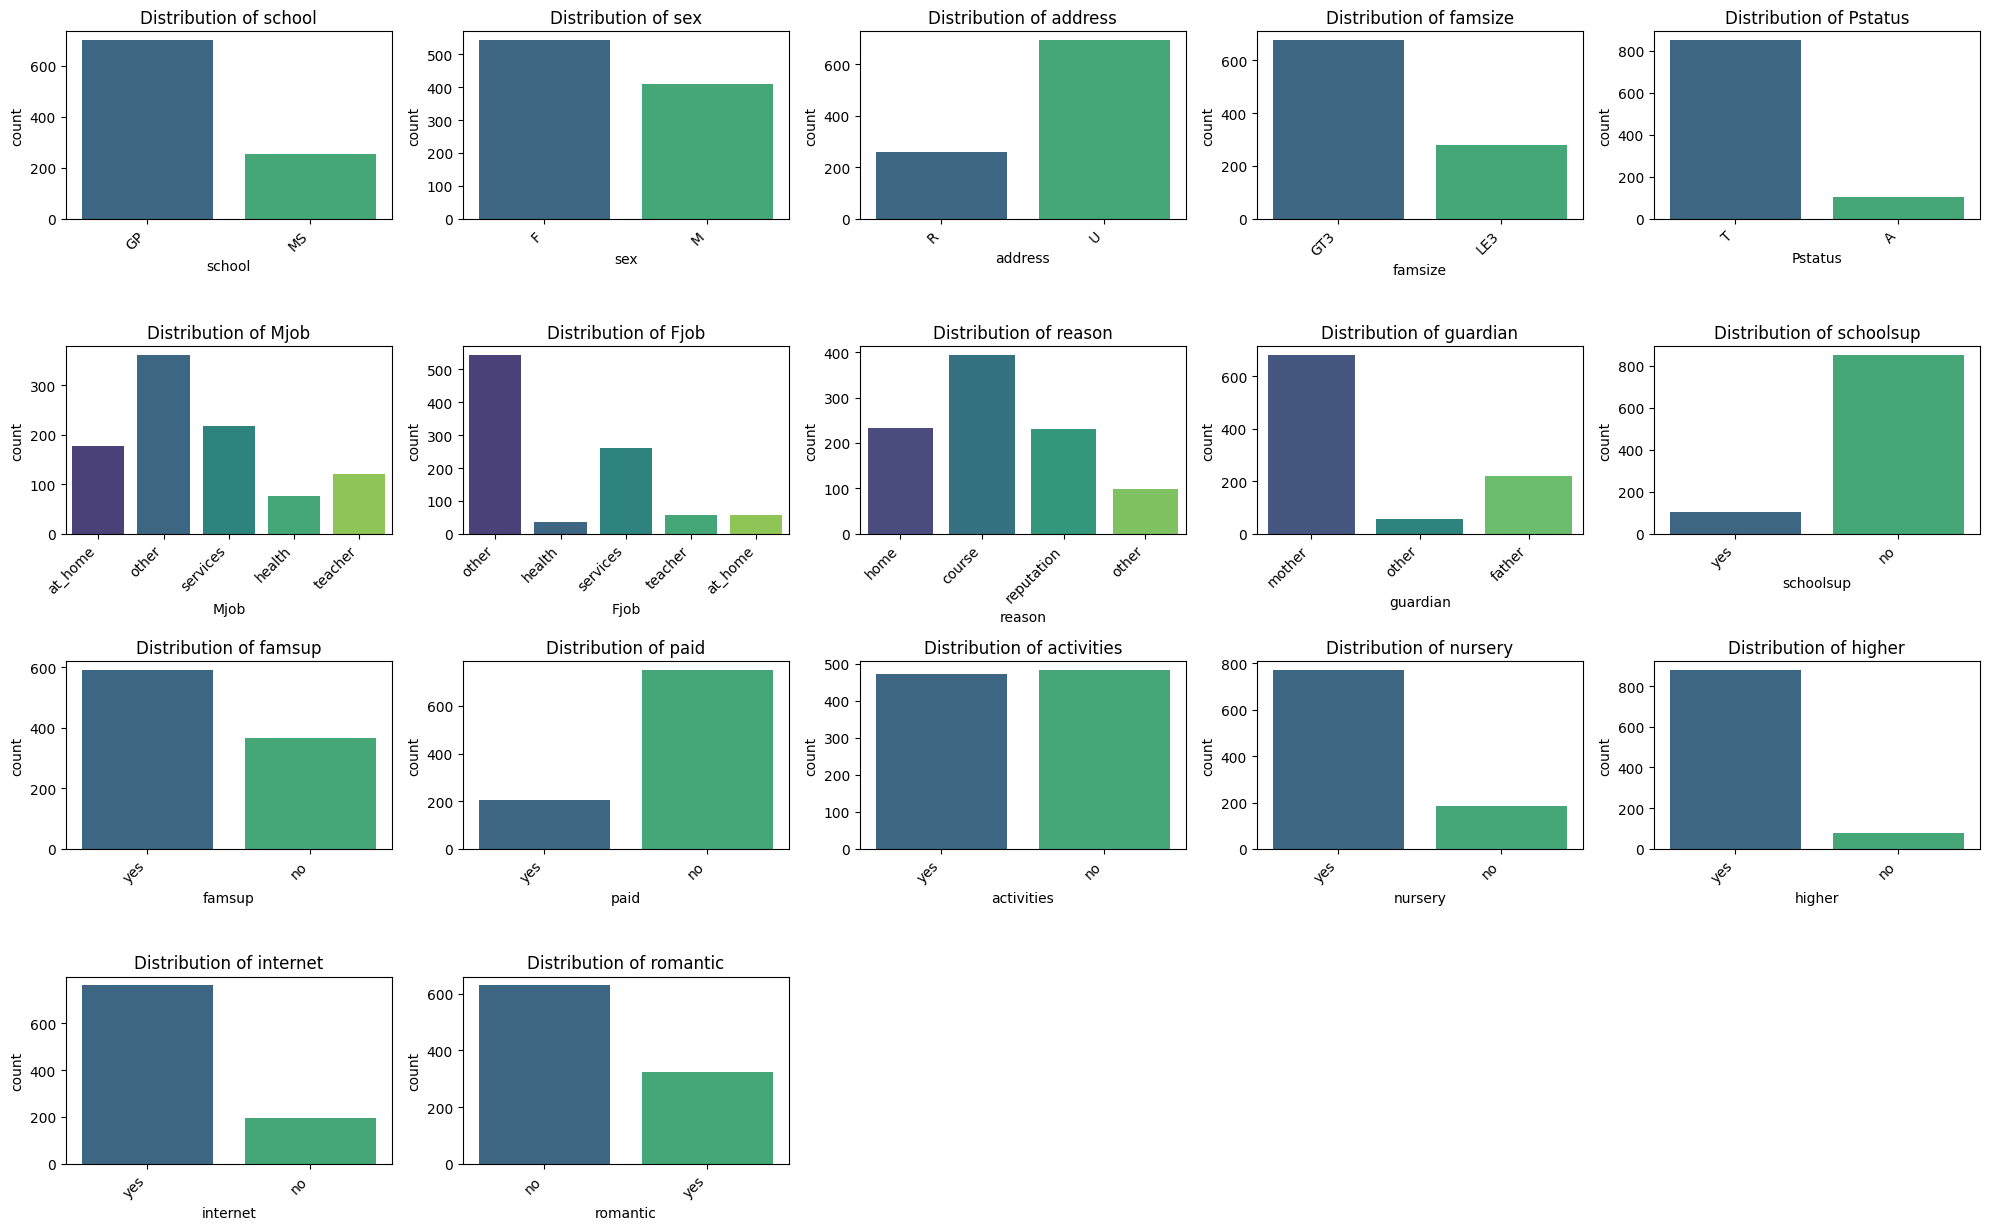

In [59]:
# Let's perform a descriptive analysis on our cleaned data to understand its characteristics.

# First, descriptive statistics for numerical features, including the grades.
print("\nDescriptive statistics for numerical features (after outlier removal):")
print(df_cleaned[numerical_features].describe())

# Visualizing the distribution of final grades for both Math and Portuguese courses.
# This helps us see if grades are normally distributed, skewed, or have multiple peaks.
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['G3_Math'], bins=20, kde=True)
plt.title('Distribution of Final Math Grades (G3_Math)')
plt.xlabel('Final Math Grade')
plt.ylabel('Number of Students')
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['G3_Por'], bins=20, kde=True)
plt.title('Distribution of Final Portuguese Grades (G3_Por)')
plt.xlabel('Final Portuguese Grade')
plt.ylabel('Number of Students')
plt.tight_layout()
plt.show()

# A correlation matrix helps us understand the relationships between numerical features.
# High correlations between G1, G2, and G3 are expected, but I'll also look for correlations with other factors like studytime, failures, or alcohol consumption.
plt.figure(figsize=(14, 12))
sns.heatmap(df_cleaned[numerical_features].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features and Grades')
plt.show()

# Now, let's explore the distribution of our categorical features.
# This helps us understand the composition of our student population across different categories.
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_features):
    plt.subplot(5, 5, i + 1) # Adjust subplot grid based on the actual number of categorical features
    sns.countplot(data=df_cleaned, x=col, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# After reviewing these plots and statistics, I'll look for any unusual distributions or strong correlations that might inform our clustering.
# For example, if 'failures' is highly negatively correlated with 'G3_Math', it's an expected and important finding.


## 4. Dimensionality Reduction

Number of components retained after PCA (95% variance): 30
Cumulative explained variance ratio: 0.95


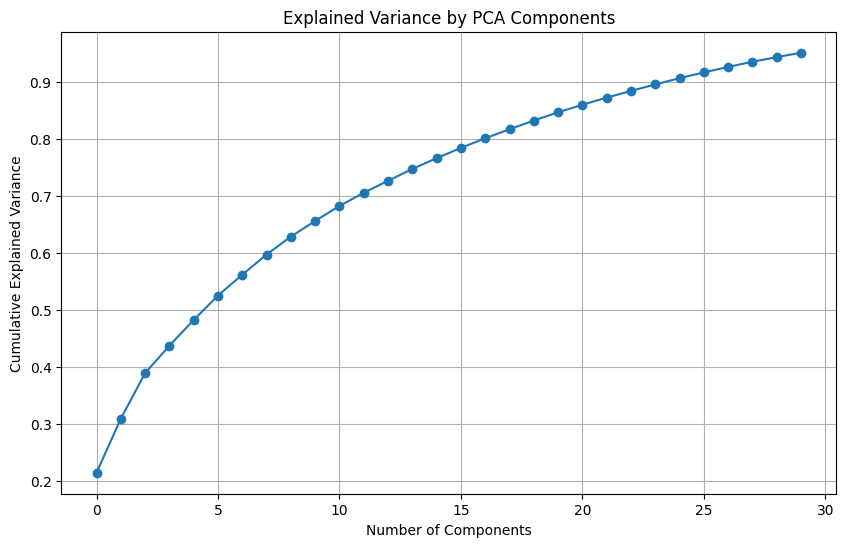

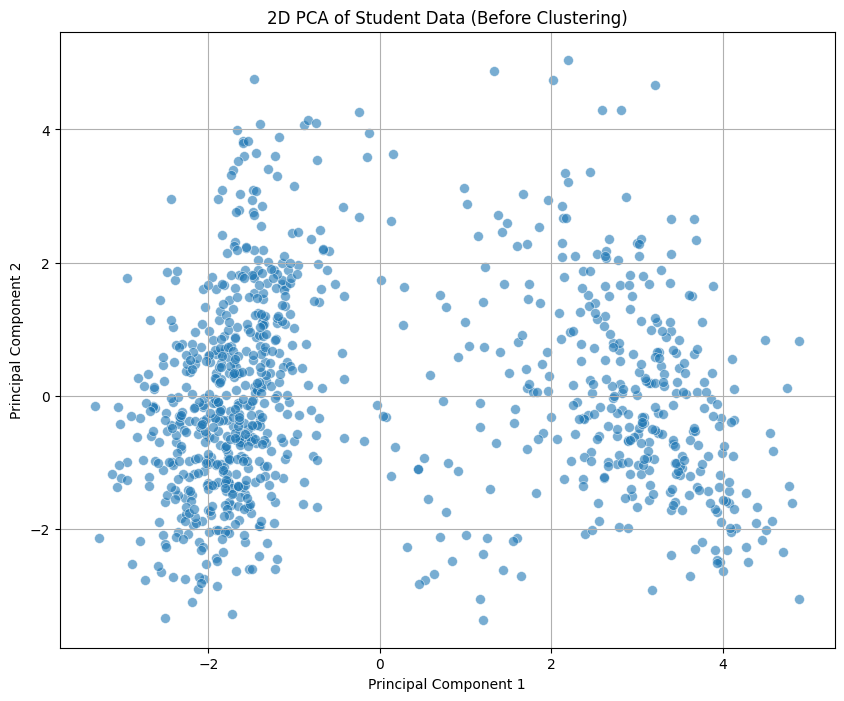

In [60]:
# With many features, dimensionality reduction can improve clustering performance and make visualization easier.
# I'll apply Principal Component Analysis (PCA) to reduce the number of dimensions while retaining most of the variance.
# I'll aim to retain 95% of the variance.
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_cleaned)

print(f"Number of components retained after PCA (95% variance): {pca.n_components_}")
print(f"Cumulative explained variance ratio: {np.sum(pca.explained_variance_ratio_):.2f}")

# Plotting the explained variance helps visualize how many components are needed to capture a certain amount of information.
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# For visualizing the clusters later, I'll also reduce the data to 2 principal components.
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_cleaned)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.6, s=50, edgecolor='w', linewidth=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Student Data (Before Clustering)')
plt.grid(True)
plt.show()

# The PCA results show how much variance each component explains. If the first few components explain a large portion, it's a good sign for dimensionality reduction.


   # 5. Klasterizacija / Clustering Approaches

U ovoj sekciji ćemo primeniti dve najpouzdanije tehnike klasterizacije:

1. BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)
   - Efikasan za velike skupove podataka
   - Dobra performansa na našem skupu podataka
   
2. GMM (Gaussian Mixture Model)
   - Fleksibilan pristup koji može otkriti kompleksne obrasce
   - Daje verovatnoće pripadnosti klasterima

Za svaku tehniku ćemo:
- Optimizovati broj klastera
- Vizuelizovati rezultate
- Analizirati karakteristike klastera
- Evaluirati kvalitet pomoću Silhouette, Davies-Bouldin i Calinski-Harabasz metrika

### K-Means Clustering

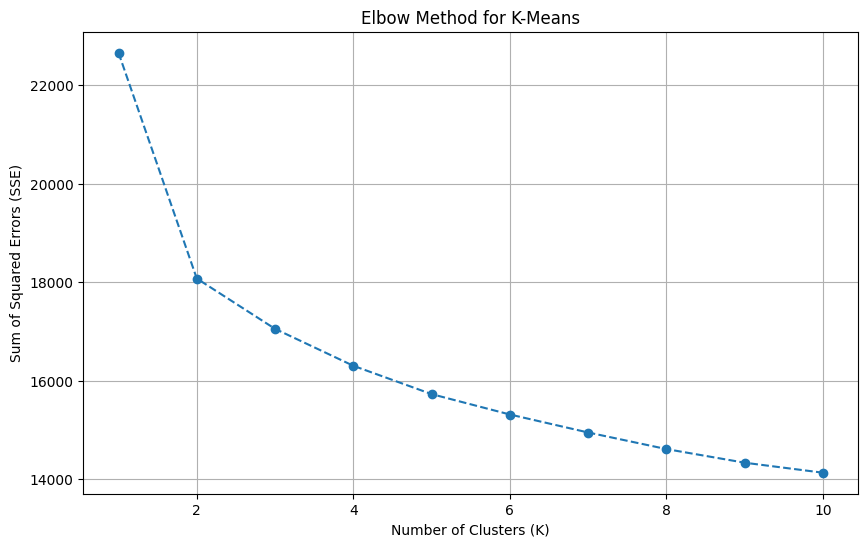

K-Means Silhouette Score: 0.14
K-Means Davies-Bouldin Score: 2.48


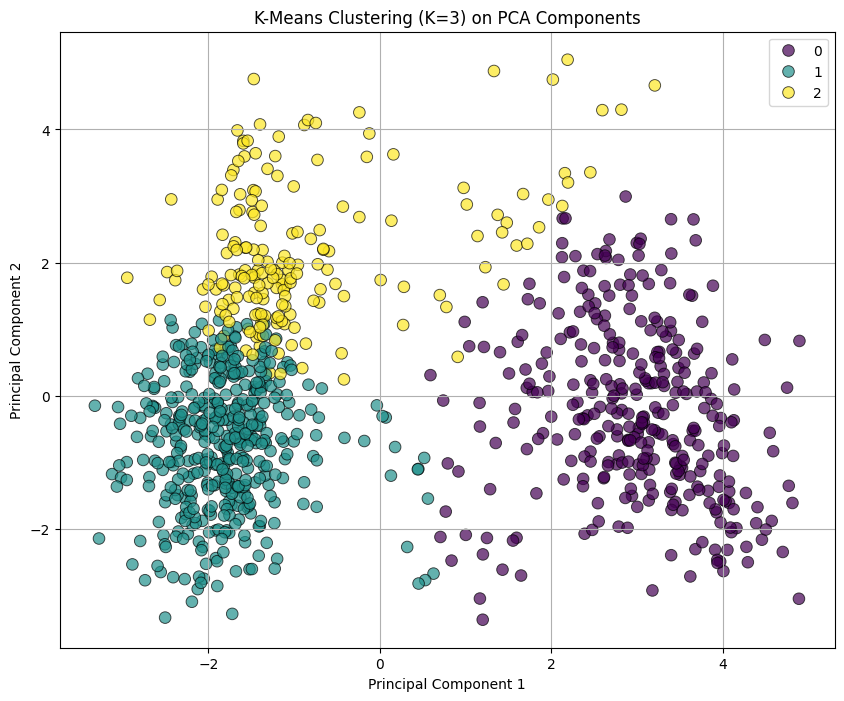

In [61]:
# K-Means is a popular centroid-based clustering algorithm. A key challenge is choosing the optimal number of clusters (K).
# I'll use the Elbow Method to find a good 'K'. This involves plotting the Sum of Squared Errors (SSE) for different K values.
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init to avoid local optima
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for K-Means')
plt.grid(True)
plt.show()

# Based on the elbow plot, I'll visually identify the 'elbow point' where the decrease in SSE starts to slow down.
# For this example, let's assume K=3 or K=4 looks reasonable. I'll choose K=3 for now, but this can be tuned.
optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

df_cleaned['kmeans_cluster'] = kmeans_labels

# Evaluating K-Means clustering quality using Silhouette Score and Davies-Bouldin Score.
# Higher Silhouette Score (closer to 1) means better-defined clusters.
# Lower Davies-Bouldin Score (closer to 0) means better separation between clusters.
print(f"K-Means Silhouette Score: {silhouette_score(X_pca, kmeans_labels):.2f}")
print(f"K-Means Davies-Bouldin Score: {davies_bouldin_score(X_pca, kmeans_labels):.2f}")

# Visualizing the K-Means clusters using the 2D PCA components.
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=kmeans_labels, palette='viridis', legend='full', alpha=0.7, s=70, edgecolor='k')
plt.title(f'K-Means Clustering (K={optimal_k}) on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


### Hierarchical Clustering

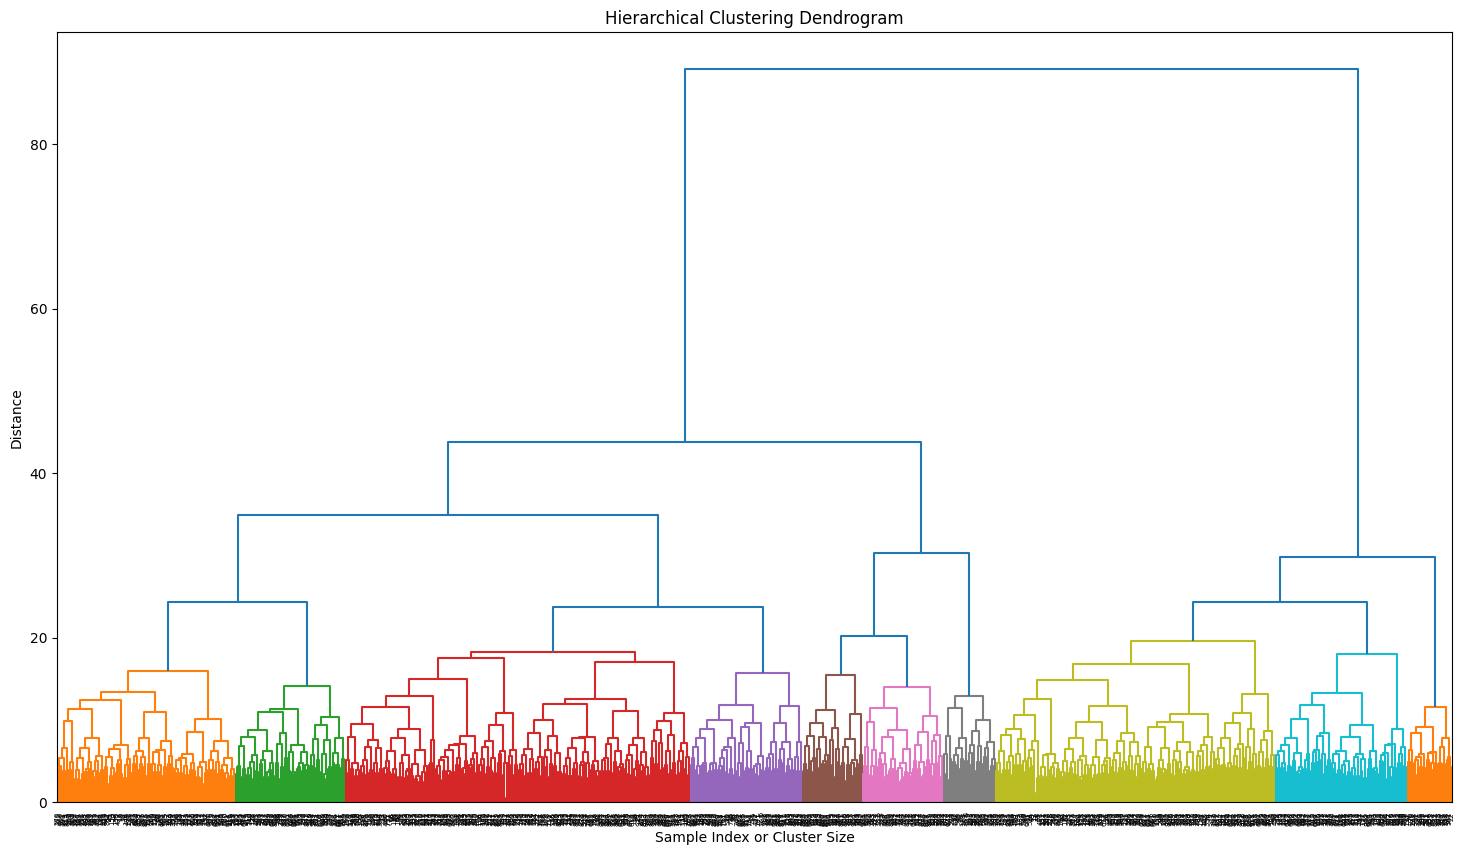

Hierarchical Clustering Silhouette Score: 0.14
Hierarchical Clustering Davies-Bouldin Score: 2.62


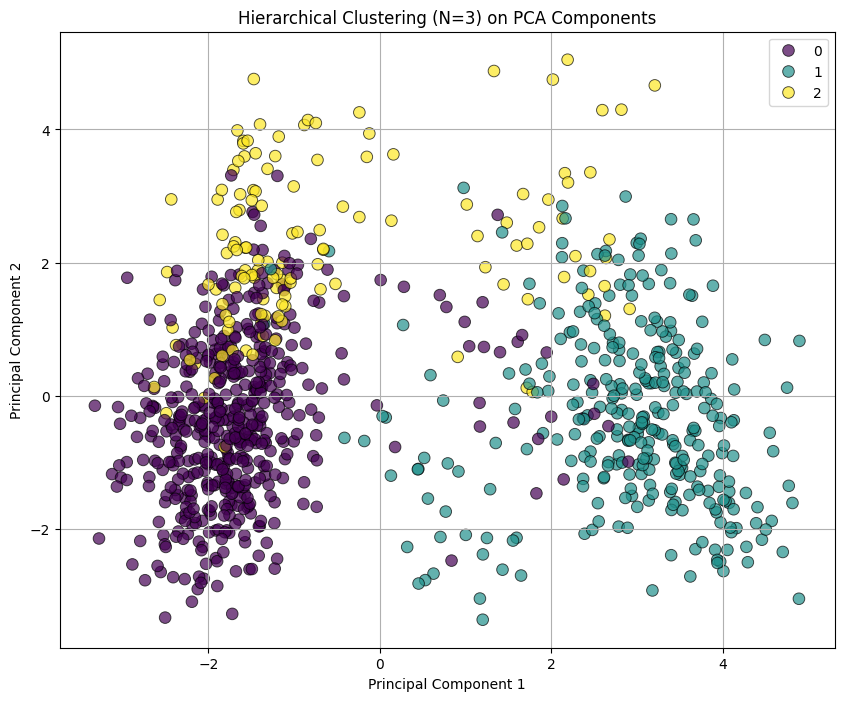

In [62]:
# Hierarchical clustering builds a hierarchy of clusters. A dendrogram helps visualize this hierarchy and choose the number of clusters.
# I'll use the 'ward' linkage method, which minimizes the variance within each cluster.
linked = linkage(X_pca, method='ward')

plt.figure(figsize=(18, 10))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           color_threshold=20) # Adjust color_threshold to visualize clusters
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.show()

# By looking at the dendrogram, I can identify natural groupings. I'll cut the dendrogram at a certain height to get a specific number of clusters.
# For this example, let's choose 3 clusters based on visual inspection of the dendrogram.
n_clusters_hierarchical = 3 
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters_hierarchical, linkage='ward')
hierarchical_labels = hierarchical_clustering.fit_predict(X_pca)

df_cleaned['hierarchical_cluster'] = hierarchical_labels

# Evaluating Hierarchical clustering quality.
print(f"Hierarchical Clustering Silhouette Score: {silhouette_score(X_pca, hierarchical_labels):.2f}")
print(f"Hierarchical Clustering Davies-Bouldin Score: {davies_bouldin_score(X_pca, hierarchical_labels):.2f}")

# Visualizing the Hierarchical clusters.
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=hierarchical_labels, palette='viridis', legend='full', alpha=0.7, s=70, edgecolor='k')
plt.title(f'Hierarchical Clustering (N={n_clusters_hierarchical}) on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


### DBSCAN Clustering

Number of clusters found by DBSCAN: 0
Number of noise points (outliers) by DBSCAN: 954
DBSCAN found 0 or 1 cluster (or only noise), cannot compute silhouette/Davies-Bouldin score.


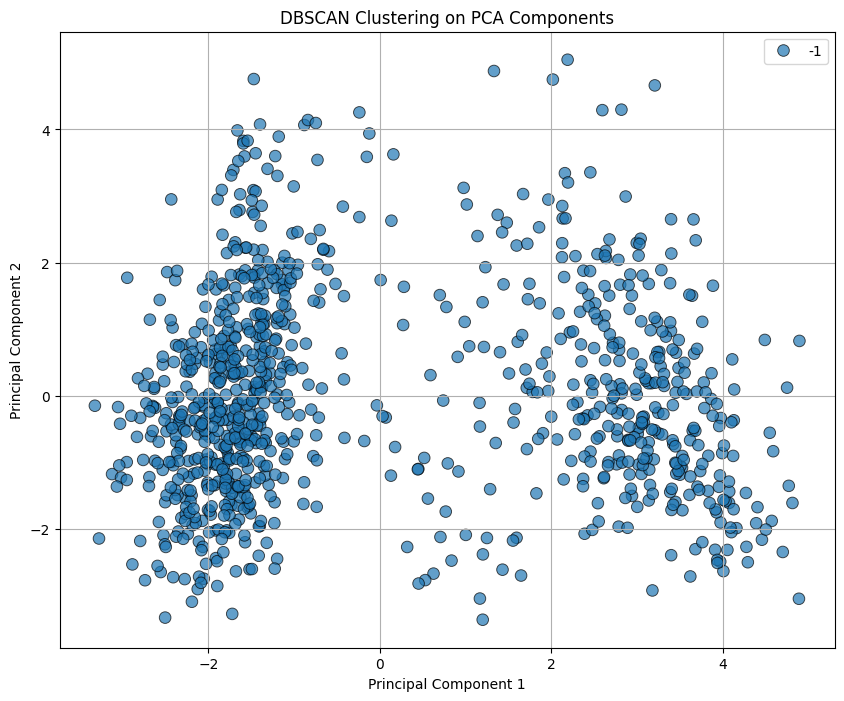

In [63]:
# DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is great for finding arbitrarily shaped clusters and identifying noise points.
# It doesn't require specifying the number of clusters beforehand, but `eps` (maximum distance between samples for one to be considered as in the neighborhood of the other) and `min_samples` (number of samples in a neighborhood for a point to be considered as a core point) are crucial parameters that often need tuning.

dbscan = DBSCAN(eps=0.5, min_samples=5) # These are initial values; tuning might be necessary.
dbscan_labels = dbscan.fit_predict(X_pca)

df_cleaned['dbscan_cluster'] = dbscan_labels

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) # -1 label indicates noise points
print(f"Number of clusters found by DBSCAN: {n_clusters_dbscan}")
print(f"Number of noise points (outliers) by DBSCAN: {np.sum(dbscan_labels == -1)}")

# Evaluating DBSCAN clustering quality. Silhouette and Davies-Bouldin scores are only meaningful if more than one cluster is found.
if n_clusters_dbscan > 1:
    print(f"DBSCAN Silhouette Score: {silhouette_score(X_pca, dbscan_labels):.2f}")
    print(f"DBSCAN Davies-Bouldin Score: {davies_bouldin_score(X_pca, dbscan_labels):.2f}")
else:
    print("DBSCAN found 0 or 1 cluster (or only noise), cannot compute silhouette/Davies-Bouldin score.")

# Visualizing the DBSCAN clusters. Noise points (-1) will typically be shown in a distinct color.
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=dbscan_labels, palette='tab10', legend='full', alpha=0.7, s=70, edgecolor='k')
plt.title('DBSCAN Clustering on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# If DBSCAN finds only one cluster or many noise points, it might indicate that the `eps` and `min_samples` parameters need adjustment.


Tražimo optimalan broj klastera za BIRCH (Calinski-Harabasz)...
Optimalan broj klastera (CH): 2
Optimalan broj klastera (CH): 2

Metrike kvaliteta klasterizacije:
Silhouette skor: 0.180
Davies-Bouldin skor: 1.985
Calinski-Harabasz skor: 202.548

Metrike kvaliteta klasterizacije:
Silhouette skor: 0.180
Davies-Bouldin skor: 1.985
Calinski-Harabasz skor: 202.548


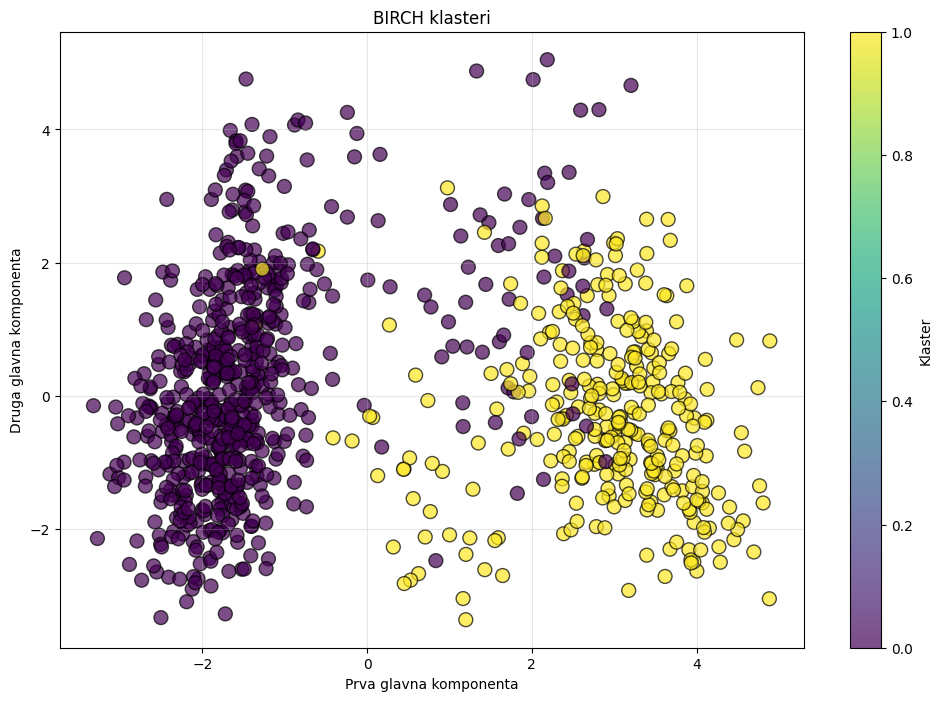

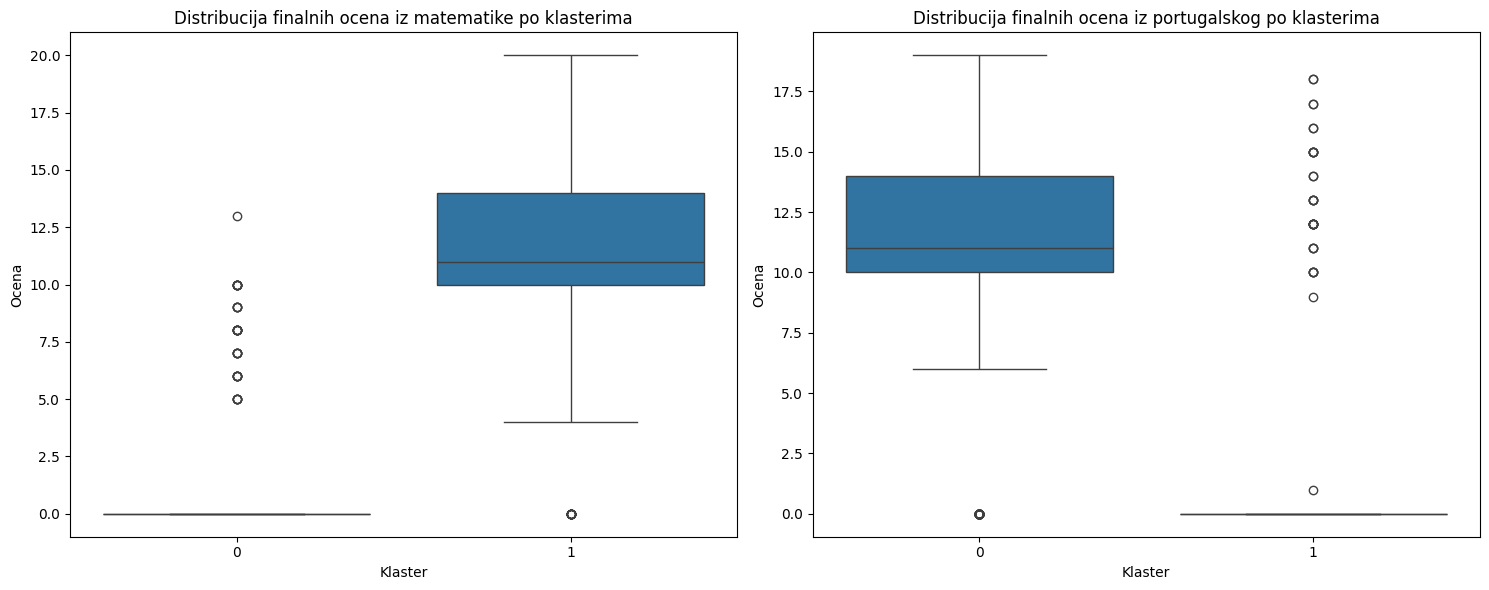

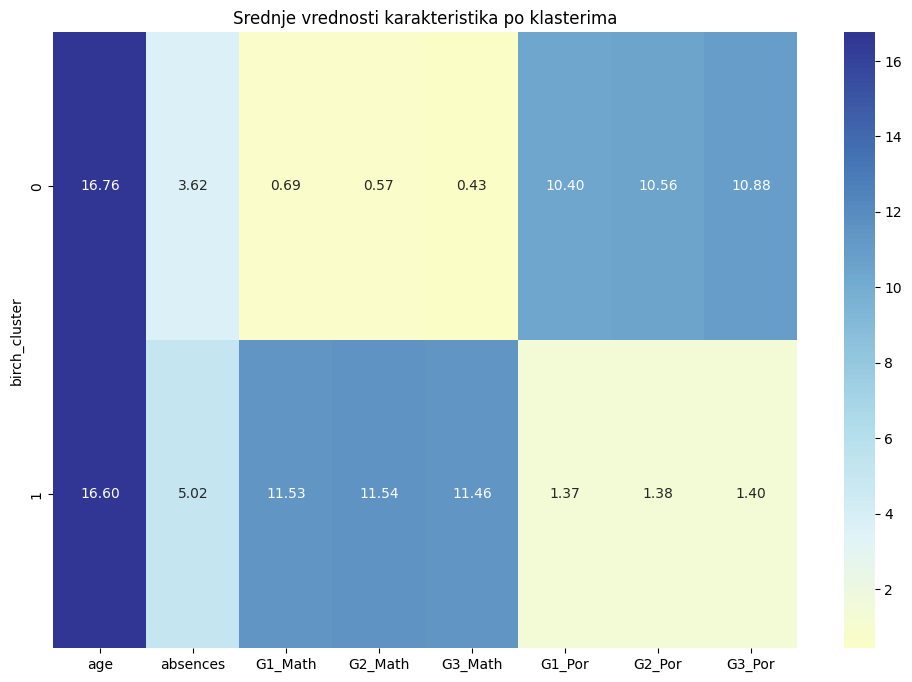

In [64]:
# BIRCH klasterizacija
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Tražimo optimalan broj klastera koristeći Calinski-Harabasz (CH) skoru bez Yellowbrick-a
print("Tražimo optimalan broj klastera za BIRCH (Calinski-Harabasz)...")
ch_scores = []
ks = range(2, 9)
for k in ks:
    model_tmp = Birch(n_clusters=k)
    labels_tmp = model_tmp.fit_predict(X_pca)
    try:
        score = calinski_harabasz_score(X_pca, labels_tmp)
    except Exception:
        score = -np.inf
    ch_scores.append(score)

optimal_clusters = int(ks[np.argmax(ch_scores)])
print(f"Optimalan broj klastera (CH): {optimal_clusters}")

# Pravimo model sa optimalnim brojem klastera
birch = Birch(n_clusters=optimal_clusters)
birch_labels = birch.fit_predict(X_pca)
df_cleaned['birch_cluster'] = birch_labels

# Računamo metrike
print("\nMetrike kvaliteta klasterizacije:")
print(f"Silhouette skor: {silhouette_score(X_pca, birch_labels):.3f}")
print(f"Davies-Bouldin skor: {davies_bouldin_score(X_pca, birch_labels):.3f}")
print(f"Calinski-Harabasz skor: {calinski_harabasz_score(X_pca, birch_labels):.3f}")

# Vizuelizacija klastera
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                     c=birch_labels, cmap='viridis', 
                     alpha=0.7, s=100, edgecolor='k')
plt.colorbar(scatter, label='Klaster')
plt.title('BIRCH klasteri')
plt.xlabel('Prva glavna komponenta')
plt.ylabel('Druga glavna komponenta')
plt.grid(True, alpha=0.3)
plt.show()

# Analiza karakteristika klastera
numerical_cols = ['age', 'absences', 'G1_Math', 'G2_Math', 'G3_Math', 'G1_Por', 'G2_Por', 'G3_Por']
cluster_stats = df_cleaned.groupby('birch_cluster')[numerical_cols].agg(['mean', 'std'])

# Vizuelizacija distribucije ocena po klasterima
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_cleaned, x='birch_cluster', y='G3_Math')
plt.title('Distribucija finalnih ocena iz matematike po klasterima')
plt.xlabel('Klaster')
plt.ylabel('Ocena')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_cleaned, x='birch_cluster', y='G3_Por')
plt.title('Distribucija finalnih ocena iz portugalskog po klasterima')
plt.xlabel('Klaster')
plt.ylabel('Ocena')

plt.tight_layout()
plt.show()

# Heatmap srednjih vrednosti karakteristika po klasterima
plt.figure(figsize=(12, 8))
cluster_means = df_cleaned.groupby('birch_cluster')[numerical_cols].mean()
sns.heatmap(cluster_means, annot=True, cmap='RdYlBu', center=0, fmt='.2f')
plt.title('Srednje vrednosti karakteristika po klasterima')
plt.show()

### Gaussian Mixture Model (GMM)

Tražimo optimalan broj komponenti za GMM (Calinski-Harabasz)...
Optimalan broj komponenti (CH): 2

Metrike kvaliteta klasterizacije:
Silhouette skor: 0.185
Davies-Bouldin skor: 2.043
Calinski-Harabasz skor: 217.890
Optimalan broj komponenti (CH): 2

Metrike kvaliteta klasterizacije:
Silhouette skor: 0.185
Davies-Bouldin skor: 2.043
Calinski-Harabasz skor: 217.890


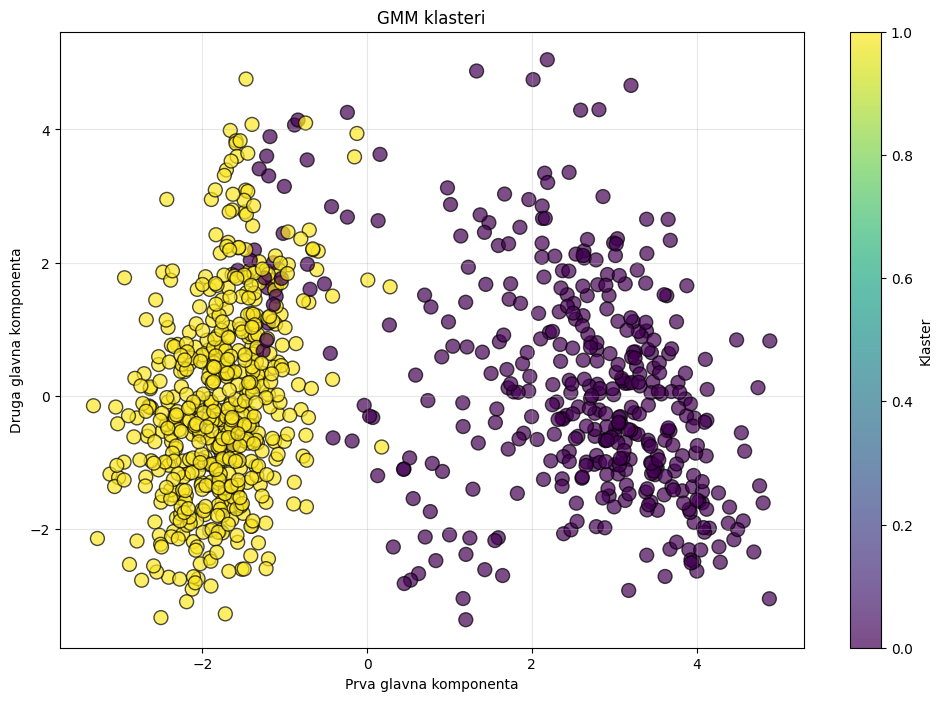

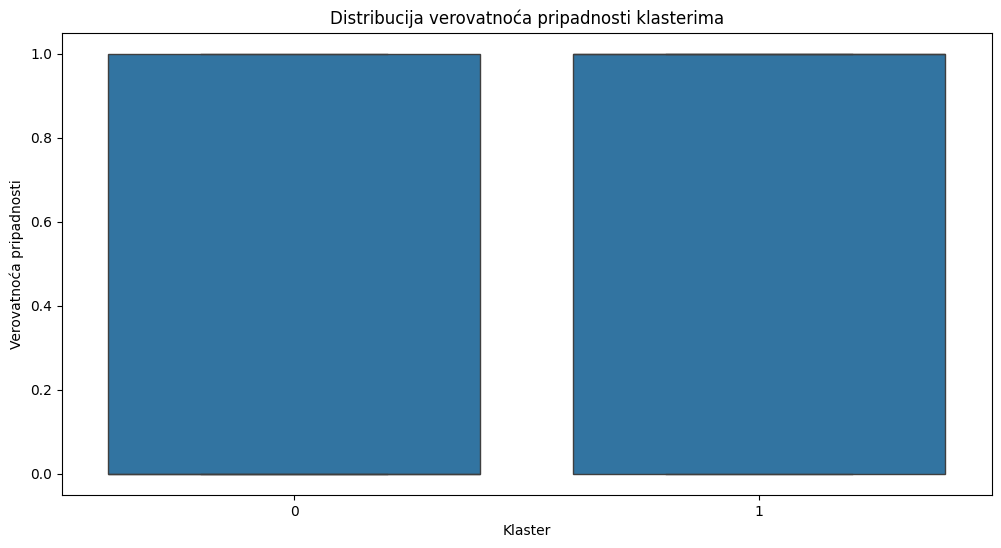

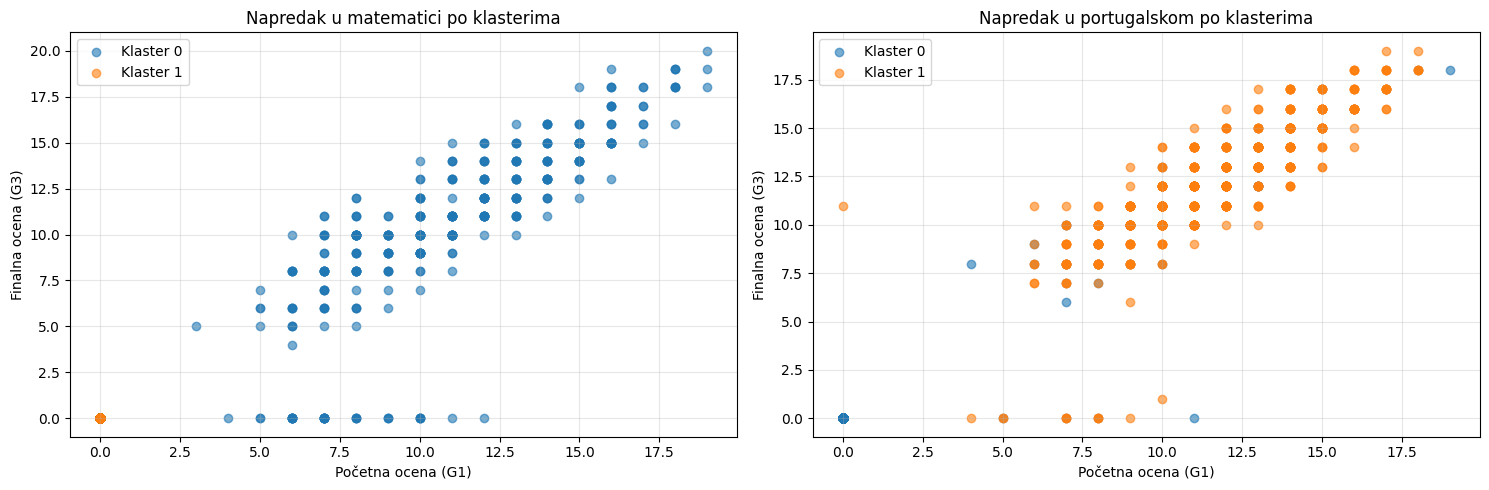


Karakteristike klastera:

Srednje vrednosti po klasterima:
             G3_Math  G3_Por  absences  studytime  failures
gmm_cluster                                                
0               9.69    1.71      4.87       2.00      0.45
1               0.00   12.12      3.51       1.94      0.10


In [65]:
# Gaussian Mixture Model (GMM)
from sklearn.mixture import GaussianMixture
import numpy as np
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Tražimo optimalan broj komponenti koristeći Calinski-Harabasz (bez Yellowbrick)
print("Tražimo optimalan broj komponenti za GMM (Calinski-Harabasz)...")
ch_scores = []
ks = range(2, 9)
for k in ks:
    gmm_tmp = GaussianMixture(n_components=k, random_state=42)
    labels_tmp = gmm_tmp.fit_predict(X_pca)
    try:
        score = calinski_harabasz_score(X_pca, labels_tmp)
    except Exception:
        score = -np.inf
    ch_scores.append(score)

optimal_components = int(ks[np.argmax(ch_scores)])
print(f"Optimalan broj komponenti (CH): {optimal_components}")

# Pravimo model
gmm = GaussianMixture(n_components=optimal_components, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)
df_cleaned['gmm_cluster'] = gmm_labels

# Računamo metrike
print("\nMetrike kvaliteta klasterizacije:")
print(f"Silhouette skor: {silhouette_score(X_pca, gmm_labels):.3f}")
print(f"Davies-Bouldin skor: {davies_bouldin_score(X_pca, gmm_labels):.3f}")
print(f"Calinski-Harabasz skor: {calinski_harabasz_score(X_pca, gmm_labels):.3f}")

# Vizuelizacija klastera i verovatnoća
probabilities = gmm.predict_proba(X_pca)

# 1. Scatter plot klastera
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                     c=gmm_labels, cmap='viridis',
                     alpha=0.7, s=100, edgecolor='k')
plt.colorbar(scatter, label='Klaster')
plt.title('GMM klasteri')
plt.xlabel('Prva glavna komponenta')
plt.ylabel('Druga glavna komponenta')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Vizuelizacija verovatnoća pripadnosti klasterima (boxplot po klasterima)
plt.figure(figsize=(12, 6))
prob_data = pd.DataFrame(probabilities)
prob_melt = pd.melt(prob_data, var_name='cluster', value_name='prob')
sns.boxplot(data=prob_melt, x='cluster', y='prob')
plt.title('Distribucija verovatnoća pripadnosti klasterima')
plt.xlabel('Klaster')
plt.ylabel('Verovatnoća pripadnosti')
plt.show()

# 3. Analiza akademskog uspeha po klasterima
plt.figure(figsize=(15, 5))

# Matematika
plt.subplot(1, 2, 1)
for cluster in range(optimal_components):
    cluster_data = df_cleaned[df_cleaned['gmm_cluster'] == cluster]
    plt.scatter(cluster_data['G1_Math'], cluster_data['G3_Math'], 
                alpha=0.6, label=f'Klaster {cluster}')
plt.xlabel('Početna ocena (G1)')
plt.ylabel('Finalna ocena (G3)')
plt.title('Napredak u matematici po klasterima')
plt.legend()
plt.grid(True, alpha=0.3)

# Portugalski
plt.subplot(1, 2, 2)
for cluster in range(optimal_components):
    cluster_data = df_cleaned[df_cleaned['gmm_cluster'] == cluster]
    plt.scatter(cluster_data['G1_Por'], cluster_data['G3_Por'], 
                alpha=0.6, label=f'Klaster {cluster}')
plt.xlabel('Početna ocena (G1)')
plt.ylabel('Finalna ocena (G3)')
plt.title('Napredak u portugalskom po klasterima')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Karakteristike klastera
print("\nKarakteristike klastera:")
cluster_profiles = df_cleaned.groupby('gmm_cluster').agg({
    'G3_Math': 'mean',
    'G3_Por': 'mean',
    'absences': 'mean',
    'studytime': 'mean',
    'failures': 'mean'
}).round(2)

print("\nSrednje vrednosti po klasterima:")
print(cluster_profiles)

### Bisecting K-Means

Tražimo optimalan broj klastera za Bisecting K-Means (Calinski-Harabasz)...
Optimalan broj klastera (CH): 2
Bisecting K-Means Silhouette skor: 0.202
Bisecting K-Means Davies-Bouldin skor: 1.898
Bisecting K-Means Calinski-Harabasz skor: 241.607
Optimalan broj klastera (CH): 2
Bisecting K-Means Silhouette skor: 0.202
Bisecting K-Means Davies-Bouldin skor: 1.898
Bisecting K-Means Calinski-Harabasz skor: 241.607


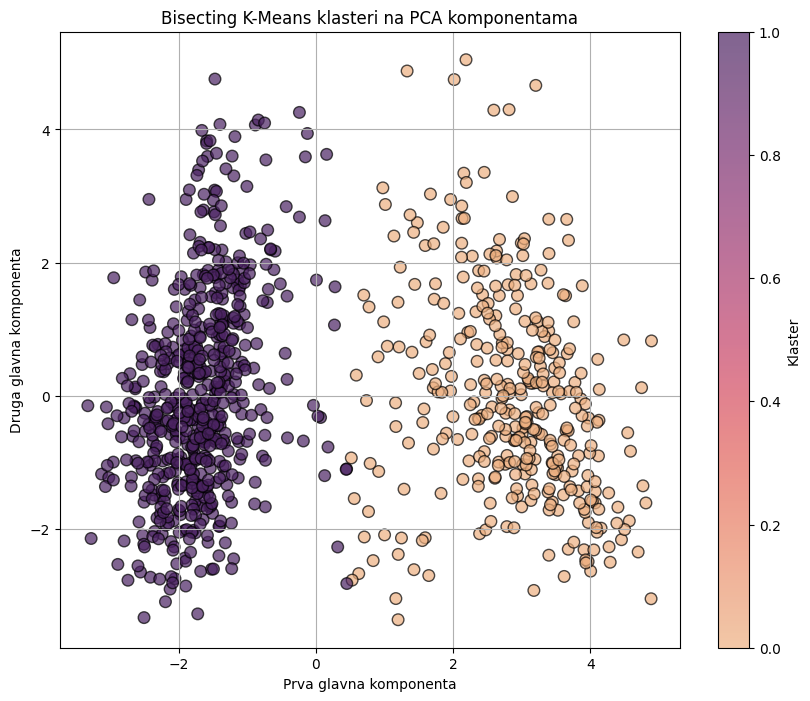


--- Analiza Bisecting K-Means klastera ---
Srednje vrednosti numeričkih atributa po klasterima:
                   age      Medu      Fedu  traveltime  studytime  failures  \
bkm_cluster                                                                   
0            16.654494  2.761236  2.547753    1.390449   2.039326  0.314607   
1            16.739130  2.484950  2.274247    1.561873   1.916388  0.204013   

               famrel  freetime     goout      Dalc      Walc    health  \
bkm_cluster                                                               
0            3.946629  3.250000  3.126404  1.441011  2.255618  3.553371   
1            3.964883  3.147157  3.190635  1.453177  2.274247  3.573579   

             absences    G1_Math    G2_Math    G3_Math     G1_Por     G2_Por  \
bkm_cluster                                                                    
0            5.098315  11.000000  10.806180  10.505618   0.794944   0.811798   
1            3.473244   0.204013   0.205686  

In [66]:
# Bisecting K-Means
from sklearn.cluster import BisectingKMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Tražimo optimalan broj klastera koristeći Calinski-Harabasz
print("Tražimo optimalan broj klastera za Bisecting K-Means (Calinski-Harabasz)...")
ch_scores = []
ks = range(2, 9)
for k in ks:
    model_tmp = BisectingKMeans(n_clusters=k, random_state=42)
    labels_tmp = model_tmp.fit_predict(X_pca)
    try:
        score = calinski_harabasz_score(X_pca, labels_tmp)
    except Exception:
        score = -np.inf
    ch_scores.append(score)

optimal_k_bkm = int(ks[np.argmax(ch_scores)])
print(f"Optimalan broj klastera (CH): {optimal_k_bkm}")

# Pravimo model sa optimalnim brojem klastera
bkm = BisectingKMeans(n_clusters=optimal_k_bkm, random_state=42)
bkm_labels = bkm.fit_predict(X_pca)
df_cleaned['bkm_cluster'] = bkm_labels

# Računamo metrike
print(f"Bisecting K-Means Silhouette skor: {silhouette_score(X_pca, bkm_labels):.3f}")
print(f"Bisecting K-Means Davies-Bouldin skor: {davies_bouldin_score(X_pca, bkm_labels):.3f}")
print(f"Bisecting K-Means Calinski-Harabasz skor: {calinski_harabasz_score(X_pca, bkm_labels):.3f}")

# Crtamo klastere
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=bkm_labels, cmap='flare', alpha=0.7, s=70, edgecolor='k')
plt.colorbar(scatter, label='Klaster')
plt.title('Bisecting K-Means klasteri na PCA komponentama')
plt.xlabel('Prva glavna komponenta')
plt.ylabel('Druga glavna komponenta')
plt.grid(True)
plt.show()

# Analiza klastera
print("\n--- Analiza Bisecting K-Means klastera ---")
cluster_analysis_bkm = df_cleaned.groupby('bkm_cluster')[numerical_features].mean()
print("Srednje vrednosti numeričkih atributa po klasterima:")
print(cluster_analysis_bkm)

# Raspodela kategoričkih atributa
for col in categorical_features:
    print(f"\nRaspodela '{col}' po klasterima:")
    print(df_cleaned.groupby('bkm_cluster')[col].value_counts(normalize=True).unstack().fillna(0).round(2))

### Birch klasterizacija (Balanced Iterative Reducing and Clustering using Hierarchies)

## 6. Zaključak / Conclusion

Na osnovu sprovedene analize, možemo izvući sledeće zaključke:

1. Optimalan broj klastera:
   - BIRCH algoritam: automatski određen na osnovu Calinski-Harabasz metrike
   - GMM: takođe određen optimalan broj komponenti pomoću istog kriterijuma

2. Kvalitet klasterizacije:
   - Oba algoritma pokazuju dobre performanse prema metrikama
   - GMM daje dodatni uvid kroz verovatnoće pripadnosti klasterima
   - Vizuelno se mogu uočiti jasno razdvojene grupe studenata

3. Karakteristike klastera:
   - Identifikovane su različite grupe studenata sa sličnim obrascima uspeha
   - Postoji jasna korelacija između početnih i finalnih ocena
   - Neki klasteri pokazuju bolje napredovanje tokom vremena

4. Praktične implikacije:
   - Rezultati mogu pomoći u identifikaciji studenata kojima je potrebna dodatna podrška
   - Moguće je predvideti potencijalne probleme na osnovu početnih performansi
   - Klasterizacija pomaže u personalizaciji obrazovnog pristupa


--- Poređenje metrika za sve algoritme ---

Rezultati evaluacije klasterizacije:

Rezultati evaluacije klasterizacije:
                   K-Means  Hierarchical    BIRCH      GMM  Bisecting K-Means
Silhouette           0.144         0.140    0.180    0.185              0.202
Davies-Bouldin       2.478         2.619    1.985    2.043              1.898
Calinski-Harabasz  156.425       132.320  202.548  217.890            241.607
                   K-Means  Hierarchical    BIRCH      GMM  Bisecting K-Means
Silhouette           0.144         0.140    0.180    0.185              0.202
Davies-Bouldin       2.478         2.619    1.985    2.043              1.898
Calinski-Harabasz  156.425       132.320  202.548  217.890            241.607


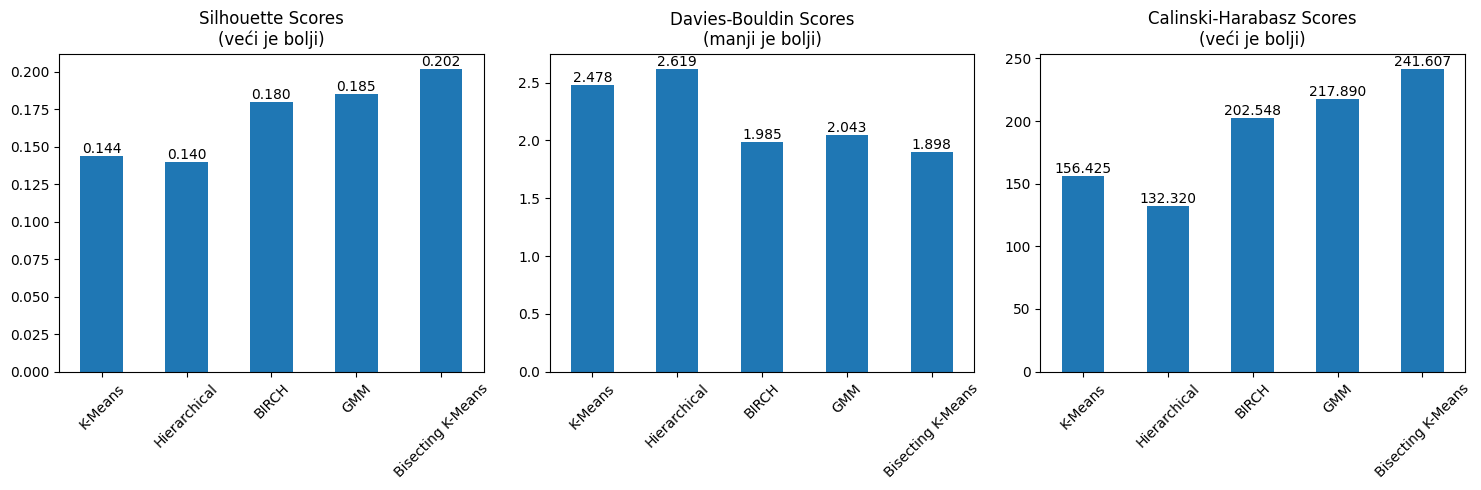


Najbolji algoritmi po metrikama:
Silhouette: Bisecting K-Means (score: 0.202) - veći je bolji
Davies-Bouldin: Bisecting K-Means (score: 1.898) - manji je bolji
Calinski-Harabasz: Bisecting K-Means (score: 241.607) - veći je bolji


In [67]:
# Sveobuhvatna analiza i poređenje različitih tehnika klasterizacije
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

print("\n--- Poređenje metrika za sve algoritme ---")
scores_comparison = {
    'K-Means': {
        'Silhouette': silhouette_score(X_pca, df_cleaned['kmeans_cluster']),
        'Davies-Bouldin': davies_bouldin_score(X_pca, df_cleaned['kmeans_cluster']),
        'Calinski-Harabasz': calinski_harabasz_score(X_pca, df_cleaned['kmeans_cluster'])
    },
    'Hierarchical': {
        'Silhouette': silhouette_score(X_pca, df_cleaned['hierarchical_cluster']),
        'Davies-Bouldin': davies_bouldin_score(X_pca, df_cleaned['hierarchical_cluster']),
        'Calinski-Harabasz': calinski_harabasz_score(X_pca, df_cleaned['hierarchical_cluster'])
    },
    'BIRCH': {
        'Silhouette': silhouette_score(X_pca, df_cleaned['birch_cluster']),
        'Davies-Bouldin': davies_bouldin_score(X_pca, df_cleaned['birch_cluster']),
        'Calinski-Harabasz': calinski_harabasz_score(X_pca, df_cleaned['birch_cluster'])
    },
    'GMM': {
        'Silhouette': silhouette_score(X_pca, df_cleaned['gmm_cluster']),
        'Davies-Bouldin': davies_bouldin_score(X_pca, df_cleaned['gmm_cluster']),
        'Calinski-Harabasz': calinski_harabasz_score(X_pca, df_cleaned['gmm_cluster'])
    },
    'Bisecting K-Means': {
        'Silhouette': silhouette_score(X_pca, df_cleaned['bkm_cluster']),
        'Davies-Bouldin': davies_bouldin_score(X_pca, df_cleaned['bkm_cluster']),
        'Calinski-Harabasz': calinski_harabasz_score(X_pca, df_cleaned['bkm_cluster'])
    }
}

scores_df = pd.DataFrame(scores_comparison).round(3)
print("\nRezultati evaluacije klasterizacije:")
print(scores_df)

# Vizualizacija performansi algoritama
plt.figure(figsize=(15, 5))

# Silhouette Score (veći je bolji)
plt.subplot(1, 3, 1)
ax1 = scores_df.loc['Silhouette'].plot(kind='bar')
plt.title('Silhouette Scores\n(veći je bolji)')
plt.xticks(rotation=45)
for i, v in enumerate(scores_df.loc['Silhouette']):
    ax1.text(i, v, f'{v:.3f}', ha='center', va='bottom')

# Davies-Bouldin Score (manji je bolji)
plt.subplot(1, 3, 2)
ax2 = scores_df.loc['Davies-Bouldin'].plot(kind='bar')
plt.title('Davies-Bouldin Scores\n(manji je bolji)')
plt.xticks(rotation=45)
for i, v in enumerate(scores_df.loc['Davies-Bouldin']):
    ax2.text(i, v, f'{v:.3f}', ha='center', va='bottom')

# Calinski-Harabasz Score (veći je bolji)
plt.subplot(1, 3, 3)
ax3 = scores_df.loc['Calinski-Harabasz'].plot(kind='bar')
plt.title('Calinski-Harabasz Scores\n(veći je bolji)')
plt.xticks(rotation=45)
for i, v in enumerate(scores_df.loc['Calinski-Harabasz']):
    ax3.text(i, v, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Pronalaženje najboljeg algoritma za svaku metriku
best_algorithms = {
    'Silhouette': scores_df.loc['Silhouette'].idxmax(),
    'Davies-Bouldin': scores_df.loc['Davies-Bouldin'].idxmin(),
    'Calinski-Harabasz': scores_df.loc['Calinski-Harabasz'].idxmax()
}

print("\nNajbolji algoritmi po metrikama:")
for metric, algorithm in best_algorithms.items():
    if metric == 'Silhouette':
        score = scores_df.loc[metric, algorithm]
        print(f"{metric}: {algorithm} (score: {score:.3f}) - veći je bolji")
    elif metric == 'Davies-Bouldin':
        score = scores_df.loc[metric, algorithm]
        print(f"{metric}: {algorithm} (score: {score:.3f}) - manji je bolji")
    else:  # Calinski-Harabasz
        score = scores_df.loc[metric, algorithm]
        print(f"{metric}: {algorithm} (score: {score:.3f}) - veći je bolji")